Install Dependencies

In [39]:
import pandas as pd 
import numpy as np
import sklearn as linear_model
from sklearn.linear_model import LinearRegression # Linear regression model for price forcasting
import matplotlib.pyplot as plt
import statistics
import yfinance as yf


What else we need:

Stock Dataset (can choose any one, download from yahoo finance)
Market Index Dataset
High/Low forecast dataframes + regression lines
Train model on high/low forecasts
Forecast prices + plot data

Can add features, but this is basic setup for stock price forcaster.

Import Stock Dataset
-- Data set must have the following features: "Open", "High", "Low", "Close", "Volume"
-- Data set must have the most recent 20 rows of historical data from the previous 20 weeks for the stock (in order by date)
-- Time period per entry must be a week as the forecast is predicting next week's data

Import Market Index Dataset
-- Dataset must have Open/Close
-- Must have most recent 20 rows of historical data for 20 weeks of stock
-- Time period per entry must be 1 week as forecast predicts next weeks data

In [40]:
# Function to fetch and preprocess stock data
def fetch_and_preprocess(ticker_symbol):
    # Fetch 1 year of stock data
    Stock_df = yf.download(ticker_symbol, period='1y')

    # Clean the dataset to only include necessary columns
    Stock_df = Stock_df[['Open','High', 'Low', 'Close', 'Volume']]

    # Trimming the last 2 rows 
    Stock_df = Stock_df.iloc[:-2]

    # Compute 'Index_returns' for the stock
    Stock_df['Index_returns'] = (Stock_df['Close'] - Stock_df['Open']) / Stock_df['Open'] * 100

    # Add 'Stock' column to identify the ticker
    Stock_df['Stock'] = ticker_symbol

    # Reset the index to get 'Date' as a column 
    Stock_df.reset_index(inplace=True)
    
    return Stock_df


# Stocks that we are going to implement
tickers = ["AAPL", "^IXIC", "AMZN", "ADBE"]

# Empty list to hold all preprocessed DataFrames
all_data = []

for ticker in tickers:
    all_data.append(fetch_and_preprocess(ticker))

combined_df = pd.concat(all_data, ignore_index=True)

# Usage Example
print("\nThe following is the cleaned and transformed dataset the program will be using: ")
combined_df
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


The following is the cleaned and transformed dataset the program will be using: 


,Date,Open,High,Low,Close,Volume,Index_returns,Stock
0,2023-04-05,164.740005,165.050003,161.800003,163.759995,51511700,-0.594883,AAPL
1,2023-04-06,162.429993,164.960007,162.000000,164.660004,45390100,1.372906,AAPL
2,2023-04-10,161.419998,162.029999,160.080002,162.029999,47716900,0.377897,AAPL
3,2023-04-11,162.350006,162.360001,160.509995,160.800003,47644200,-0.954729,AAPL
4,2023-04-12,161.220001,162.059998,159.779999,160.100006,50133100,-0.694700,AAPL
...,...,...,...,...,...,...,...,...
991,2024-03-26,508.059998,512.789978,503.589996,507.600006,2813300,-0.090539,ADBE
992,2024-03-27,515.469971,516.859985,499.700012,504.399994,4228400,-2.147550,ADBE
993,2024-03-28,508.119995,509.000000,500.260010,504.600006,3897000,-0.692748,ADBE
994,2024-04-01,504.989990,506.920013,499.309998,502.089996,2056000,-0.574268,ADBE


In [41]:
#Creates a new dataframe to graph weekly charts

def create_weekly_data(dataframe):
    # Ensure that 'Date' is the datetime index
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date']).copy()
        dataframe.set_index('Date', inplace=True)

    # Resample data to get weekly averages
    weekly_data = dataframe[dataframe.index.dayofweek == 0]

    return weekly_data

# Usage example
weekly_data = create_weekly_data(combined_df)
weekly_data


,Open,High,Low,Close,Volume,Index_returns,Stock
Date,,,,,,,
2023-04-10,161.419998,162.029999,160.080002,162.029999,47716900,0.377897,AAPL
2023-04-17,165.089996,165.389999,164.029999,165.229996,41516200,0.084802,AAPL
2023-04-24,165.000000,165.600006,163.889999,165.330002,41949600,0.200001,AAPL
2023-05-01,169.279999,170.449997,168.639999,169.589996,52472900,0.183127,AAPL
2023-05-08,172.479996,173.850006,172.110001,173.500000,55962800,0.591375,AAPL
...,...,...,...,...,...,...,...
2024-03-04,572.849976,576.250000,564.099976,567.940002,2556400,-0.857113,ADBE
2024-03-11,552.450012,562.690002,551.020020,560.419983,2857800,1.442659,ADBE
2024-03-18,495.549988,515.729980,495.549988,513.859985,7052700,3.694884,ADBE


High Prices Forecasts

In [42]:
# High Price Forecast Dataframe
def HighPrice(dataframe):

    # Group by 'Stock' and shift the 'High' prices up to get the projected high prices for the next day
    dataframe['ProjectedHigh'] = dataframe.groupby('Stock')['High'].shift(-1)

    # Drop any rows that now have NaN in 'ProjectedHigh' due to the shift 
    dataframe = dataframe.dropna(subset=['ProjectedHigh'])

    del dataframe["Open"]

    return dataframe


# Print transformed dataframe.
print("High Forecast")
ProjectedHighForecast = HighPrice(combined_df)
ProjectedHighForecast


High Forecast


,High,Low,Close,Volume,Index_returns,Stock,ProjectedHigh
Date,,,,,,,
2023-04-05,165.050003,161.800003,163.759995,51511700,-0.594883,AAPL,164.960007
2023-04-06,164.960007,162.000000,164.660004,45390100,1.372906,AAPL,162.029999
2023-04-10,162.029999,160.080002,162.029999,47716900,0.377897,AAPL,162.360001
2023-04-11,162.360001,160.509995,160.800003,47644200,-0.954729,AAPL,162.059998
2023-04-12,162.059998,159.779999,160.100006,50133100,-0.694700,AAPL,165.800003
...,...,...,...,...,...,...,...
2024-03-25,510.630005,496.690002,507.230011,4277000,2.101492,ADBE,512.789978
2024-03-26,512.789978,503.589996,507.600006,2813300,-0.090539,ADBE,516.859985
2024-03-27,516.859985,499.700012,504.399994,4228400,-2.147550,ADBE,509.000000


In [43]:
# Suppress the SettingWithCopyWarning error
pd.options.mode.chained_assignment = None  

def WeeklyHighPrice(dataframe):    
    # Group by 'Stock' and shift the 'High' prices up to get the projected high prices for the next week
    dataframe['ProjectedHigh'] = dataframe.groupby('Stock')['High'].shift(-1)

    # Drop any rows that now have NaN in 'ProjectedHigh' due to the shift 
    dataframe = dataframe.dropna(subset=['ProjectedHigh'])

    del dataframe["Open"]

    return dataframe

# Print transformed dataframe.
print("Weekly High Forecast")
weekly_forecast = WeeklyHighPrice(weekly_data)
weekly_forecast

Weekly High Forecast


,High,Low,Close,Volume,Index_returns,Stock,ProjectedHigh
Date,,,,,,,
2023-04-10,162.029999,160.080002,162.029999,47716900,0.377897,AAPL,165.389999
2023-04-17,165.389999,164.029999,165.229996,41516200,0.084802,AAPL,165.600006
2023-04-24,165.600006,163.889999,165.330002,41949600,0.200001,AAPL,170.449997
2023-05-01,170.449997,168.639999,169.589996,52472900,0.183127,AAPL,173.850006
2023-05-08,173.850006,172.110001,173.500000,55962800,0.591375,AAPL,173.210007
...,...,...,...,...,...,...,...
2024-02-26,570.599976,556.559998,560.479980,4251200,0.704324,ADBE,576.250000
2024-03-04,576.250000,564.099976,567.940002,2556400,-0.857113,ADBE,562.690002
2024-03-11,562.690002,551.020020,560.419983,2857800,1.442659,ADBE,515.729980


Low Price Forecasts

In [44]:
# Low Price Forecast Dataframe
def LowPrice(dataframe):
    # Group by 'Stock' and shift the 'Low' prices up to get the projected low prices for the next day
    dataframe['ProjectedLow'] = dataframe.groupby('Stock')['Low'].shift(-1)

    # Drop any rows that now have NaN in 'ProjectedLow' due to the shift
    dataframe = dataframe.dropna(subset=['ProjectedLow'])

    del dataframe["Open"]

    return dataframe
    
# Print transformed dataframe
print("Low Forecast")
ProjectedLowForecast = LowPrice(combined_df)
ProjectedLowForecast

Low Forecast


,High,Low,Close,Volume,Index_returns,Stock,ProjectedHigh,ProjectedLow
Date,,,,,,,,
2023-04-05,165.050003,161.800003,163.759995,51511700,-0.594883,AAPL,164.960007,162.000000
2023-04-06,164.960007,162.000000,164.660004,45390100,1.372906,AAPL,162.029999,160.080002
2023-04-10,162.029999,160.080002,162.029999,47716900,0.377897,AAPL,162.360001,160.509995
2023-04-11,162.360001,160.509995,160.800003,47644200,-0.954729,AAPL,162.059998,159.779999
2023-04-12,162.059998,159.779999,160.100006,50133100,-0.694700,AAPL,165.800003,161.419998
...,...,...,...,...,...,...,...,...
2024-03-25,510.630005,496.690002,507.230011,4277000,2.101492,ADBE,512.789978,503.589996
2024-03-26,512.789978,503.589996,507.600006,2813300,-0.090539,ADBE,516.859985,499.700012
2024-03-27,516.859985,499.700012,504.399994,4228400,-2.147550,ADBE,509.000000,500.260010


In [45]:
def WeeklyLowPrice(dataframe):
    # Group by 'Stock' and shift the 'Low' prices up to get the projected low prices for the next week
    dataframe['ProjectedLow'] = dataframe.groupby('Stock')['Low'].shift(-1)

    # Drop any rows that now have NaN in 'ProjectedLow' due to the shift 
    dataframe = dataframe.dropna(subset=['ProjectedLow'])

    del dataframe["Open"]

    return dataframe

# Print transformed dataframe.
print("Weekly High Forecast")
weekly_forecast = WeeklyLowPrice(weekly_data)
weekly_forecast


Weekly High Forecast


,High,Low,Close,Volume,Index_returns,Stock,ProjectedHigh,ProjectedLow
Date,,,,,,,,
2023-04-10,162.029999,160.080002,162.029999,47716900,0.377897,AAPL,165.389999,164.029999
2023-04-17,165.389999,164.029999,165.229996,41516200,0.084802,AAPL,165.600006,163.889999
2023-04-24,165.600006,163.889999,165.330002,41949600,0.200001,AAPL,170.449997,168.639999
2023-05-01,170.449997,168.639999,169.589996,52472900,0.183127,AAPL,173.850006,172.110001
2023-05-08,173.850006,172.110001,173.500000,55962800,0.591375,AAPL,173.210007,171.470001
...,...,...,...,...,...,...,...,...
2024-02-26,570.599976,556.559998,560.479980,4251200,0.704324,ADBE,576.250000,564.099976
2024-03-04,576.250000,564.099976,567.940002,2556400,-0.857113,ADBE,562.690002,551.020020
2024-03-11,562.690002,551.020020,560.419983,2857800,1.442659,ADBE,515.729980,495.549988


In [46]:
# High Price Forecast Regression Model
def HighPriceRegression(dataframe, stock_symbol):

    # Prepare the features and target variable for each stock
    df = dataframe[dataframe['Stock'] == stock_symbol].copy()

    # Shift high prices up to get the next day's value
    df['ProjectedHigh'] = df['High'].shift(-1) 
    
    # Drop the last row where 'ProjectedHigh' is NaN
    df = df.dropna(subset=['ProjectedHigh'])  

    # Extract features and target
    X = df[['High', 'Low', 'Close', 'Volume', 'Index_returns']]
    y = df['ProjectedHigh']
    
    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Predict the last available data point
    X_new = df.tail(1)[['High', 'Low', 'Close', 'Volume', 'Index_returns']]
    prediction = model.predict(X_new)
    
    return model, prediction, X_new

def print_regression_details(model, prediction, X_new, stock_symbol, price_type="High"):
    print(f"{price_type} Price Regression")
    print(f"Predicted {price_type} Price for {stock_symbol}: {prediction[0]}")
    print(f"{price_type}: {model.coef_[0]}")
    print(f"Low: {model.coef_[1]}")
    print(f"Close: {model.coef_[2]}")
    print(f"Volume: {model.coef_[3]}")
    print(f"Index_returns: {model.coef_[4]}")
    print(f"Intercept of {price_type} Regression Line for {stock_symbol}: {model.intercept_}")
    print()


# Usage example
stock_symbol = 'AAPL'

model_daily, prediction_daily, X_new_daily = HighPriceRegression(ProjectedHighForecast, stock_symbol)
print_regression_details(model_daily, prediction_daily, X_new_daily, stock_symbol, "Daily High")

model_weekly, prediction_weekly, X_new_weekly = HighPriceRegression(weekly_data, stock_symbol)
print_regression_details(model_weekly, prediction_weekly, X_new_weekly, stock_symbol, "Weekly High")


Daily High Price Regression
Predicted Daily High Price for AAPL: 173.07252821991327
Daily High: 0.05553804245852307
Low: 0.2066875148636389
Close: 0.713814475120435
Volume: 3.5210449000899757e-09
Index_returns: 0.32134378111786577
Intercept of Daily High Regression Line for AAPL: 5.679302436882978

Weekly High Price Regression
Predicted Weekly High Price for AAPL: 173.77921870922586
Weekly High: 0.9527054901950391
Low: -0.5216098279097773
Close: 0.39605249911244245
Volume: -1.3491125105957735e-08
Index_returns: 0.80276209499373
Intercept of Weekly High Regression Line for AAPL: 31.292879287237866



In [47]:
# Low Price Forecast Regression Model
def LowPriceRegression(dataframe, stock_symbol):

    # Prepare the features and target variable for each stock
    df = dataframe[dataframe['Stock'] == stock_symbol].copy()

    # Shift low prices up to get the next day's value
    df['ProjectedLow'] = df['Low'].shift(-1)  
    
    # Drop the last row where 'ProjectedLow' is NaN
    df = df.dropna(subset=['ProjectedLow'])  

    # Extract features and target
    X = df[['High', 'Low', 'Close', 'Volume', 'Index_returns']]
    y = df['ProjectedLow']       

    # Train the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the last available data point
    X_new = df.tail(1)[['High', 'Low', 'Close', 'Volume', 'Index_returns']]
    prediction = model.predict(X_new)


    return model, prediction, X_new

def print_regression_details(model, prediction, X_new, stock_symbol, price_type="Low"):
    print(f"{price_type} Price Regression")
    print(f"Predicted {price_type} Price for {stock_symbol}: {prediction[0]}")
    print(f"{price_type}: {model.coef_[0]}")
    print(f"Low: {model.coef_[1]}")
    print(f"Close: {model.coef_[2]}")
    print(f"Volume: {model.coef_[3]}")
    print(f"Index_returns: {model.coef_[4]}")
    print(f"Intercept of {price_type} Regression Line for {stock_symbol}: {model.intercept_}")
    print()

# Usage example
stock_symbol = 'AAPL'

model_daily_low, prediction_daily_low, X_new_daily_low = LowPriceRegression(ProjectedLowForecast, stock_symbol)
print_regression_details(model_daily_low, prediction_daily_low, X_new_daily_low, stock_symbol, "Daily Low")

model_weekly_low, prediction_weekly_low, X_new_weekly_low = LowPriceRegression(weekly_data, stock_symbol)
print_regression_details(model_weekly_low, prediction_weekly_low, X_new_weekly_low, stock_symbol, "Weekly Low")


Daily Low Price Regression
Predicted Daily Low Price for AAPL: 170.31355631976746
Daily Low: -0.00895425525533131
Low: 0.3820011986913437
Close: 0.6054130731512571
Volume: -9.691111801934937e-10
Index_returns: 0.44129125479746684
Intercept of Daily Low Regression Line for AAPL: 3.037512719555906

Weekly Low Price Regression
Predicted Weekly Low Price for AAPL: 171.28790305539306
Weekly Low: 1.2102269395373735
Low: -0.89320418661183
Close: 0.48438281202895483
Volume: -3.176929819215246e-08
Index_returns: 0.5333386342168571
Intercept of Weekly Low Regression Line for AAPL: 33.43527153831906



Need to decide on and write training code

Check if we need to implement the RMSE

Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



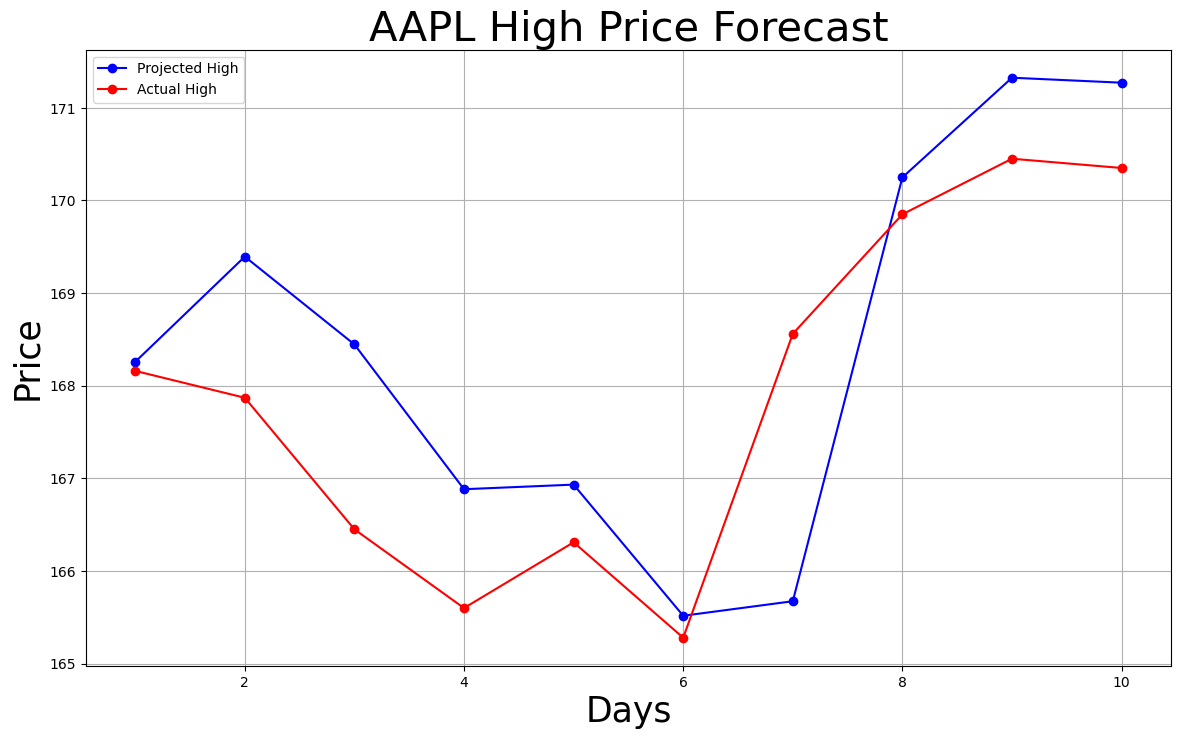

In [48]:
def calculate_high_forecast_stats(Stock_df, stock_symbol):
    Count = 0
    # 9 days for testing
    TestVal = 9 
    MeanHigh = 0
    Highs = []
    Projections = []
    Actuals = []

    stock_data = Stock_df[Stock_df['Stock'] == stock_symbol].copy()
    stock_data = stock_data.dropna(subset=['High'])

    HighRegressionModel, MeanHigh, HighSD = HighPriceRegression(stock_data, stock_symbol)

    # Predicting the high price for the next 10 days
    while Count < 10:
        TrainDF = stock_data.iloc[Count:TestVal]
        ActualHigh = stock_data.iloc[TestVal]["High"]
        ProjectionInput = TrainDF[['High', 'Low', 'Close', 'Volume', 'Index_returns']].tail(1)

        Prediction = HighRegressionModel.predict(ProjectionInput)

        Error = ((Prediction[0] / ActualHigh) - 1) * 100
        Highs.append(Error)
        MeanHigh += Error
        Projections.append(Prediction[0])
        Actuals.append(ActualHigh)
        
        Count += 1
        TestVal += 1

    MeanHigh /= 10
    HighSD = statistics.stdev(Highs)

    return MeanHigh, HighSD, Projections, Actuals

def plot_high_forecast(stock_symbol, Projections, Actuals, MeanHigh, HighSD):
    
    print("Regression Accuracy Over Past 10 Time Periods\n")
    print(f"Mean Margin of Error: {MeanHigh}%")
    print(f"Standard Deviation of Error: {HighSD}%")
    print(f"Deviation Range: {MeanHigh - HighSD}% - {MeanHigh + HighSD}%\n")
    
    TestHigh = {
        "ProjectedTime": list(range(1, len(Projections) + 1)),
        "ProjectedPrices": Projections,
        "TestTime": list(range(1, len(Actuals) + 1)),
        "TestPrices": Actuals
    }

    TestHighDF = pd.DataFrame(TestHigh)

    ax = TestHighDF.plot(x='ProjectedTime', y='ProjectedPrices', color='blue', marker='o', label='Projected High')
    TestHighDF.plot(x='TestTime', y='TestPrices', color='red', ax=ax, marker='o', label='Actual High')
    plt.xlabel("Days", fontsize=25)
    plt.ylabel("Price", fontsize=25)
    plt.title(f"{stock_symbol} High Price Forecast", fontsize=30)
    plt.rcParams["figure.figsize"] = (14, 8)
    plt.legend()
    plt.grid(True)
    plt.show()


# Usage example
stock_symbol = 'AAPL'
MeanHigh, HighSD, Projections, Actuals = calculate_high_forecast_stats(combined_df, stock_symbol)
plot_high_forecast(stock_symbol, Projections, Actuals, MeanHigh, HighSD)


Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [44.56837997]%
Standard Deviation of Error: 1.8290705915730536%
Deviation Range: [42.73930938]% - [46.39745056]%



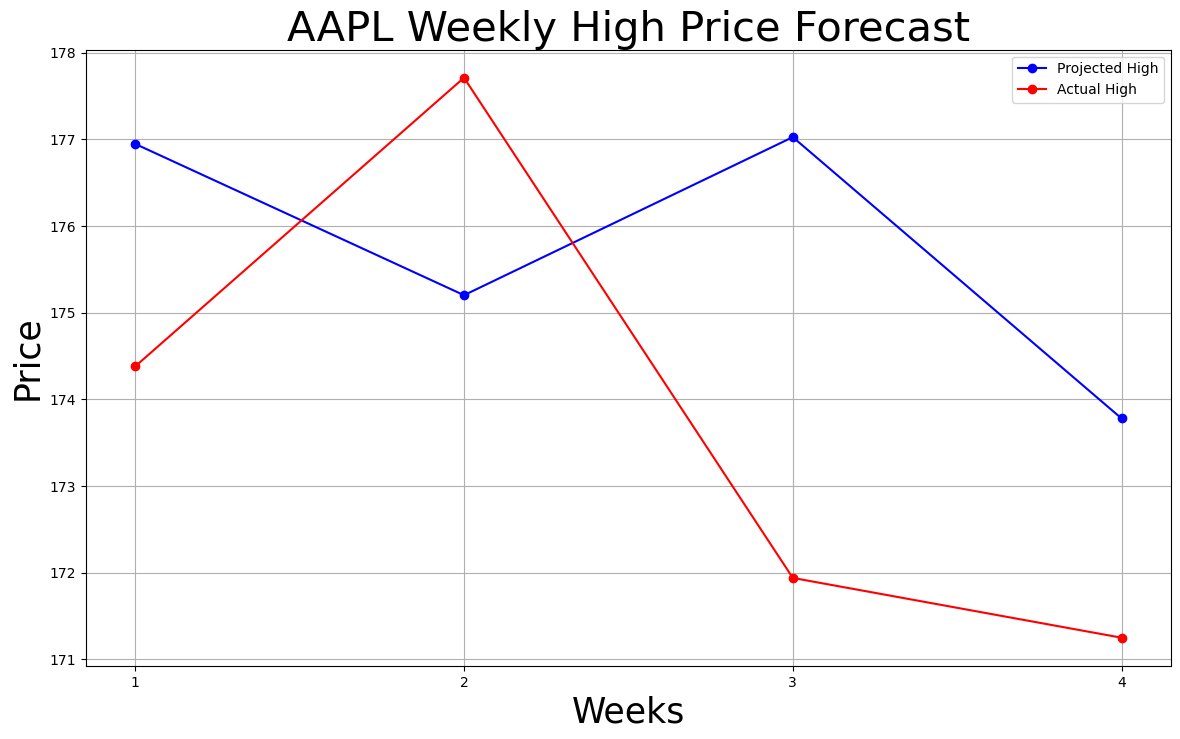

In [49]:
def train_weekly_high_forecast(Stock_df, stock_symbol):
    Count = 0
    # 4 weeks for testing
    TestVal = 4  
    Highs = []
    Projections = []
    Results = []

    stock_data = Stock_df[Stock_df['Stock'] == stock_symbol].copy()
    stock_data = stock_data.dropna(subset=['High'])

    # Ensure HighPriceRegression is adapted for weekly data
    HighRegressionModel, MeanHigh, HighSD = HighPriceRegression(stock_data, stock_symbol)

    # Predicting the high price for the next 4 weeks
    for i in range(TestVal):
        TrainDF = stock_data.iloc[:-TestVal + i]
        ProjectionTest = stock_data.iloc[-TestVal + i]["High"]
        ProjectionInput = TrainDF[['High', 'Low', 'Close', 'Volume', 'Index_returns']].tail(1)

        Prediction = HighRegressionModel.predict(ProjectionInput)
        Error = ((Prediction[0] / ProjectionTest) - 1) * 100

        Highs.append(Error)
        MeanHigh += Error
        Projections.append(Prediction[0])
        Results.append(ProjectionTest)
        
        Count += 1

    MeanHigh /= TestVal
    HighSD = statistics.stdev(Highs)

    return MeanHigh, HighSD, Projections, Results

def plot_weekly_high_forecast(Stock_df, stock_symbol):
    MeanHigh, HighSD, Projections, Results = train_weekly_high_forecast(Stock_df, stock_symbol)

    print("Regression Accuracy Over Past 10 Time Periods\n")
    print(f"Mean Margin of Error: {MeanHigh}%")
    print(f"Standard Deviation of Error: {HighSD}%")
    print(f"Deviation Range: {MeanHigh - HighSD}% - {MeanHigh + HighSD}%\n")
    
    TestHigh = {
        "ProjectedWeek": np.arange(1, len(Projections) + 1),
        "ProjectedHighPrices": Projections,
        "ActualHighPrices": Results
    }
    TestHighDF = pd.DataFrame(TestHigh)

    # Plotting the weekly high price forecast
    ax = TestHighDF.plot(x='ProjectedWeek', y='ProjectedHighPrices', color='blue', marker='o', label='Projected High')
    TestHighDF.plot(x='ProjectedWeek', y='ActualHighPrices', color='red', ax=ax, marker='o', label='Actual High')
    plt.xlabel("Weeks", fontsize=25)
    plt.ylabel("Price", fontsize=25)
    plt.title(f"{stock_symbol} Weekly High Price Forecast", fontsize=30)
    plt.legend()
    plt.grid(True)

    plt.xticks(np.arange(1, len(Projections) + 1, 1))  
    plt.show()

# Usage example
weekly_data = create_weekly_data(combined_df)
plot_weekly_high_forecast(weekly_data, 'AAPL')


Low Forecast

Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [16.9921008]%
Standard Deviation of Error: 0.6075602621856956%
Deviation Range: [16.38454053]% - [17.59966106]%



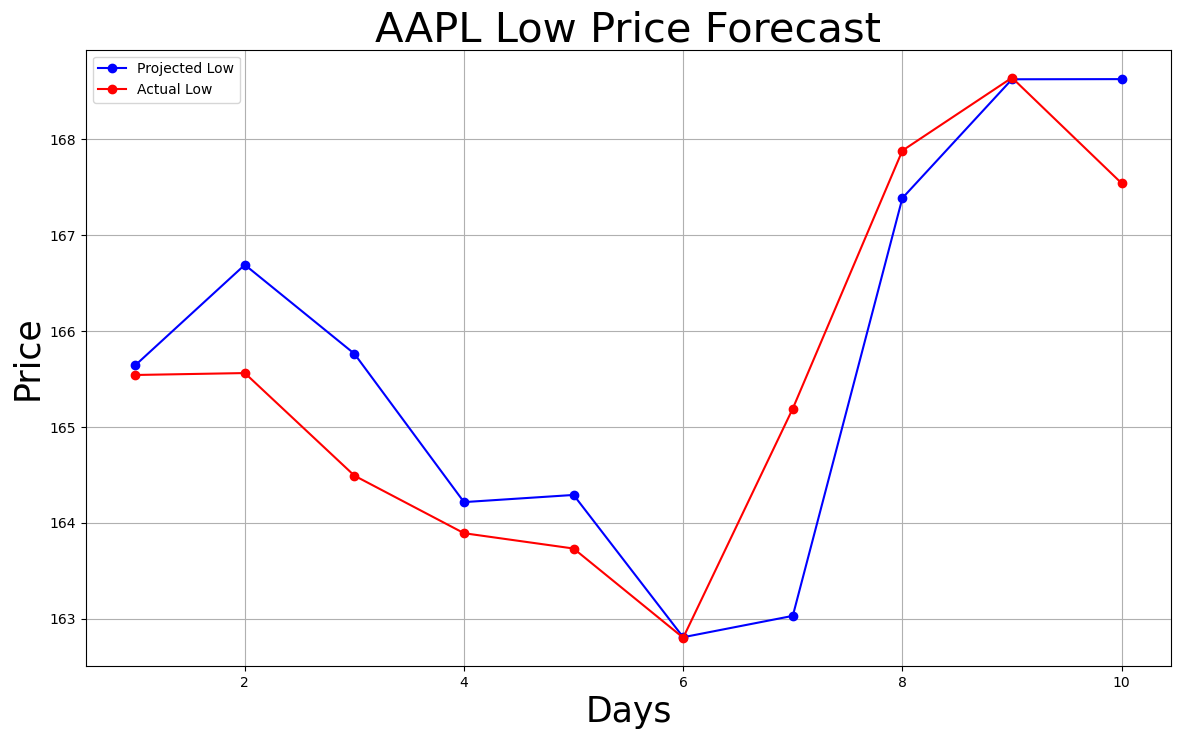

In [50]:
def calculate_low_forecast_stats(Stock_df, stock_symbol):
    Count = 0
    # 9 days for testing
    TestVal = 9 
    MeanLow = 0
    Lows = []
    Projections = []
    Actuals = []

    stock_data = Stock_df[Stock_df['Stock'] == stock_symbol].copy()
    stock_data.dropna(subset=['Low'], inplace=True)

    LowRegressionModel, MeanLow, LowSD = LowPriceRegression(stock_data, stock_symbol)

    while Count < 10:
        TrainDF = stock_data.iloc[Count:TestVal]
        ActualLow = stock_data.iloc[TestVal]["Low"]
        ProjectionInput = TrainDF[['High', 'Low', 'Close', 'Volume', 'Index_returns']].tail(1)

        Prediction = LowRegressionModel.predict(ProjectionInput)

        Error = ((Prediction[0] / ActualLow) - 1) * 100
        Lows.append(Error)
        MeanLow += Error
        Projections.append(Prediction[0])
        Actuals.append(ActualLow)
        
        Count += 1
        TestVal += 1

    MeanLow /= 10
    LowSD = statistics.stdev(Lows)

    return MeanLow, LowSD, Projections, Actuals

def plot_low_forecast(stock_symbol, Projections, Actuals, MeanLow, LowSD):
    
    print("Regression Accuracy Over Past 10 Time Periods\n")
    print(f"Mean Margin of Error: {MeanLow}%")
    print(f"Standard Deviation of Error: {LowSD}%")
    print(f"Deviation Range: {MeanLow - LowSD}% - {MeanLow + LowSD}%\n")
    
    TestLow = {
        "ProjectedTime": list(range(1, len(Projections) + 1)),
        "ProjectedPrices": Projections,
        "TestTime": list(range(1, len(Actuals) + 1)),
        "TestPrices": Actuals
    }

    TestLowDF = pd.DataFrame(TestLow)

    ax = TestLowDF.plot(x='ProjectedTime', y='ProjectedPrices', color='blue', marker='o', label='Projected Low')
    TestLowDF.plot(x='TestTime', y='TestPrices', color='red', ax=ax, marker='o', label='Actual Low')
    plt.xlabel("Days", fontsize=25)
    plt.ylabel("Price", fontsize=25)
    plt.title(f"{stock_symbol} Low Price Forecast", fontsize=30)
    plt.rcParams["figure.figsize"] = (14, 8)
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage Example
stock_symbol = 'AAPL'
MeanLow, LowSD, Projections, Actuals = calculate_low_forecast_stats(combined_df, stock_symbol)
plot_low_forecast(stock_symbol, Projections, Actuals, MeanLow, LowSD)


Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



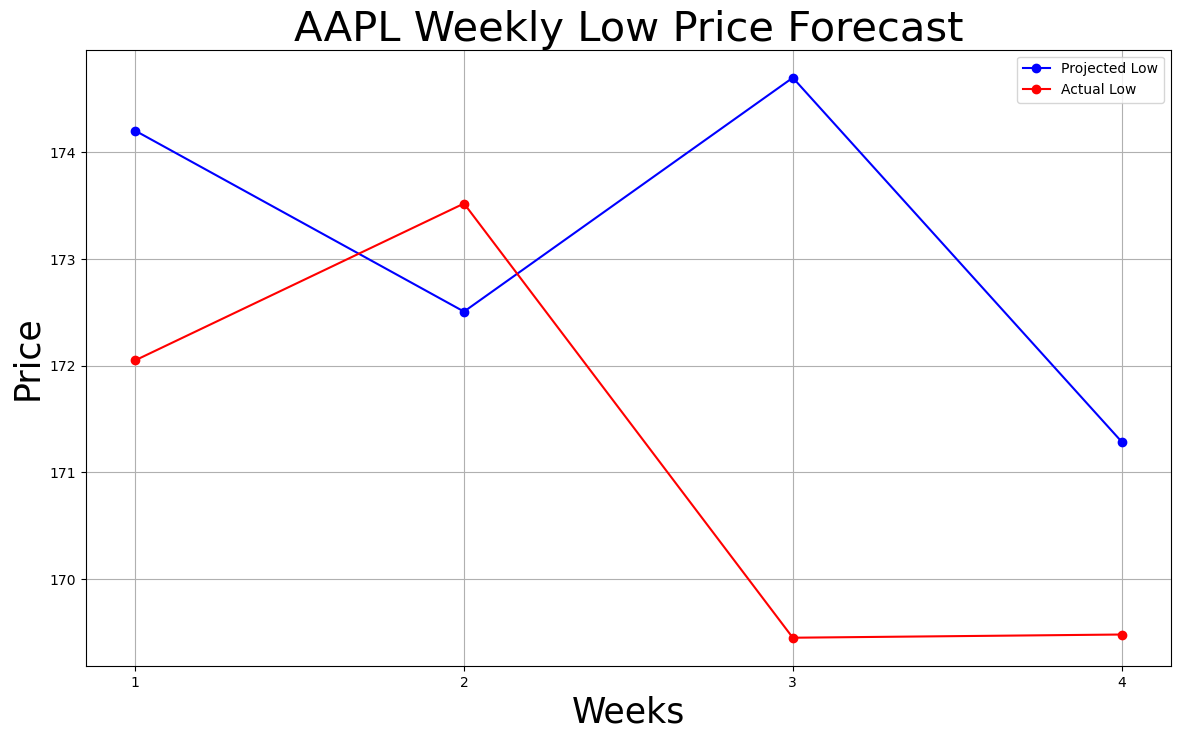

In [51]:
def train_weekly_low_forecast(Stock_df, stock_symbol):
    Count = 0
    # 4 weeks for testing
    TestVal = 4  
    Lows = []
    Projections = []
    Results = []

    stock_data = Stock_df[Stock_df['Stock'] == stock_symbol].copy()
    stock_data = stock_data.dropna(subset=['Low'])

    LowRegressionModel, _, _ = LowPriceRegression(stock_data, stock_symbol)

    MeanLow = 0

    for i in range(TestVal):
        TrainDF = stock_data.iloc[:-TestVal + i]
        ProjectionTest = stock_data.iloc[-TestVal + i]["Low"]
        ProjectionInput = TrainDF[['High', 'Low', 'Close', 'Volume', 'Index_returns']].tail(1)

        Prediction = LowRegressionModel.predict(ProjectionInput)
        Error = ((Prediction[0] / ProjectionTest) - 1) * 100

        Lows.append(Error)
        MeanLow += Error
        Projections.append(Prediction[0])
        Results.append(ProjectionTest)

        Count += 1

    MeanLow /= TestVal
    LowSD = np.std(Lows)

    return MeanLow, LowSD, Projections, Results

def plot_weekly_low_forecast(Stock_df, stock_symbol):
    MeanLow, LowSD, Projections, Results = train_weekly_low_forecast(Stock_df, stock_symbol)

    print("Regression Accuracy Over Past 10 Time Periods\n")
    print(f"Mean Margin of Error: {MeanHigh}%")
    print(f"Standard Deviation of Error: {HighSD}%")
    print(f"Deviation Range: {MeanHigh - HighSD}% - {MeanHigh + HighSD}%\n")

    TestLow = {
        "ProjectedWeek": np.arange(1, len(Projections) + 1),
        "ProjectedLowPrices": Projections,
        "ActualLowPrices": Results
    }
    TestLowDF = pd.DataFrame(TestLow)

    ax = TestLowDF.plot(x='ProjectedWeek', y='ProjectedLowPrices', color='blue', marker='o', label='Projected Low')
    TestLowDF.plot(x='ProjectedWeek', y='ActualLowPrices', color='red', ax=ax, marker='o', label='Actual Low')
    plt.xlabel("Weeks", fontsize=25)
    plt.ylabel("Price", fontsize=25)
    plt.title(f"{stock_symbol} Weekly Low Price Forecast", fontsize=30)
    plt.legend()
    plt.grid(True)

    plt.xticks(np.arange(1, len(Projections) + 1, 1))
    plt.show()

# Usage example
weekly_data = create_weekly_data(combined_df)  
plot_weekly_low_forecast(weekly_data, 'AAPL')



Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



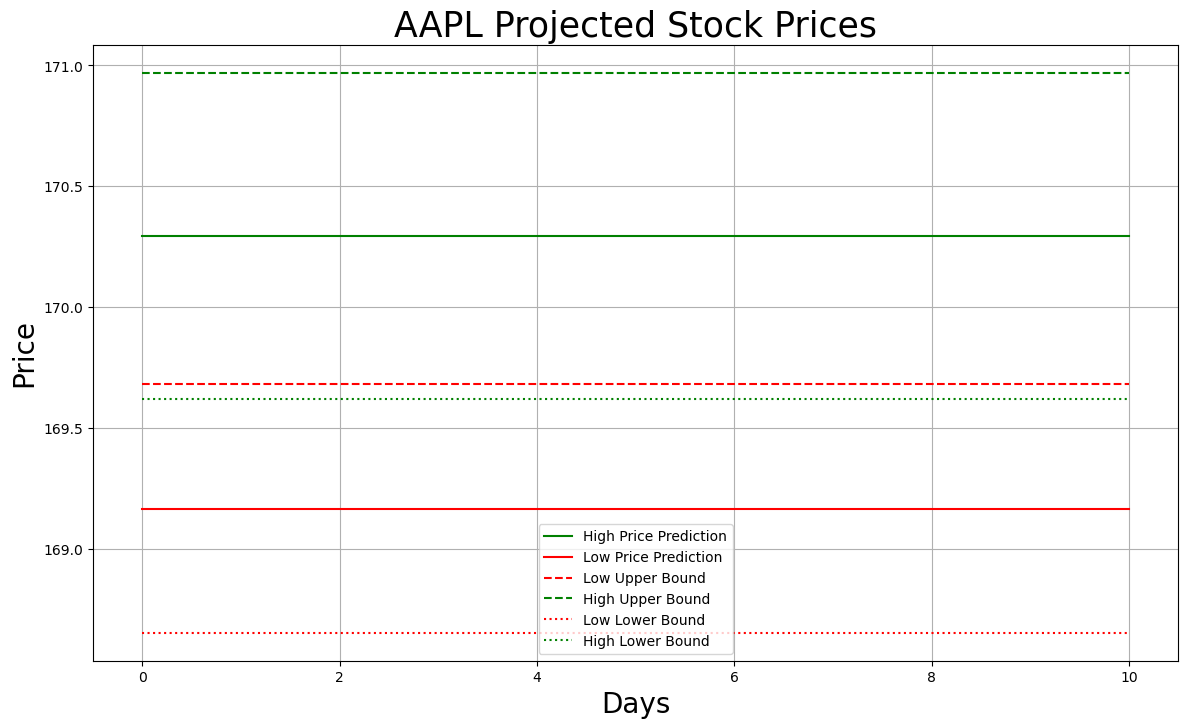

In [52]:
def forecast_prices(Stock_df, stock_symbol):

    # Call the training functions to get the necessary statistics and data
    MeanHigh, HighSD, _, _ = calculate_high_forecast_stats(Stock_df, stock_symbol)
    MeanLow, LowSD, _, _ = calculate_low_forecast_stats(Stock_df, stock_symbol)
    
    # Filter the data for the specified stock
    stock_data = Stock_df[Stock_df['Stock'] == stock_symbol].copy()

    # Get the last 10 days of data for prediction and current data to predict the next day
    TrainDF = stock_data.iloc[-10:]
    PredictedInputs = TrainDF[['High', 'Low', 'Close', 'Volume', 'Index_returns']].tail(1)

    # Forecast models
    HighRegressionModel, HighPrediction, _ = HighPriceRegression(TrainDF, stock_symbol)
    LowRegressionModel, LowPrediction, _ = LowPriceRegression(TrainDF, stock_symbol)

    # Calculate Upper/Lower Bounds for High/Low Prices
    LLB = LowPrediction - (LowPrediction * (LowSD/100)) / 2
    LUB = LowPrediction + (LowPrediction * (LowSD/100)) / 2
    HLB = HighPrediction - (HighPrediction * (HighSD/100)) / 2
    HUB = HighPrediction + (HighPrediction * (HighSD/100)) / 2


    # Prepare the data for projection

    print("Regression Accuracy Over Past 10 Time Periods\n")
    print(f"Mean Margin of Error: {MeanHigh}%")
    print(f"Standard Deviation of Error: {HighSD}%")
    print(f"Deviation Range: {MeanHigh - HighSD}% - {MeanHigh + HighSD}%\n")
    
    ProjectionChart = {
        'Time': range(11),
        'High Price Prediction': [HighPrediction[0]] * 11,
        'Low Price Prediction': [LowPrediction[0]] * 11,
        'Low Upper Bound': [LUB[0]] * 11,
        'High Upper Bound': [HUB[0]] * 11,
        'Low Lower Bound': [LLB[0]] * 11,
        'High Lower Bound': [HLB[0]] * 11
    }

    Testing = pd.DataFrame(ProjectionChart)

    # Plot the forecast and bounds
    Testing.plot(x='Time', y=['High Price Prediction', 'Low Price Prediction',
                          'Low Upper Bound', 'High Upper Bound',
                          'Low Lower Bound', 'High Lower Bound'], style=['g', 'r', 'r--', 'g--', 'r:', 'g:'])
    plt.xlabel("Days", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.title(f"{stock_symbol} Projected Stock Prices", fontsize=25)
    plt.rcParams["figure.figsize"] = (14, 8)
    plt.grid(True)
    plt.show()

# Usage example
forecast_prices(combined_df, 'AAPL')


Regression Accuracy Over Past 4 Time Periods

Mean Margin of Error: [17.09974558]%
Standard Deviation of Error: 2.996089893086281%
Deviation Range: [14.10365569]% - [20.09583547]%



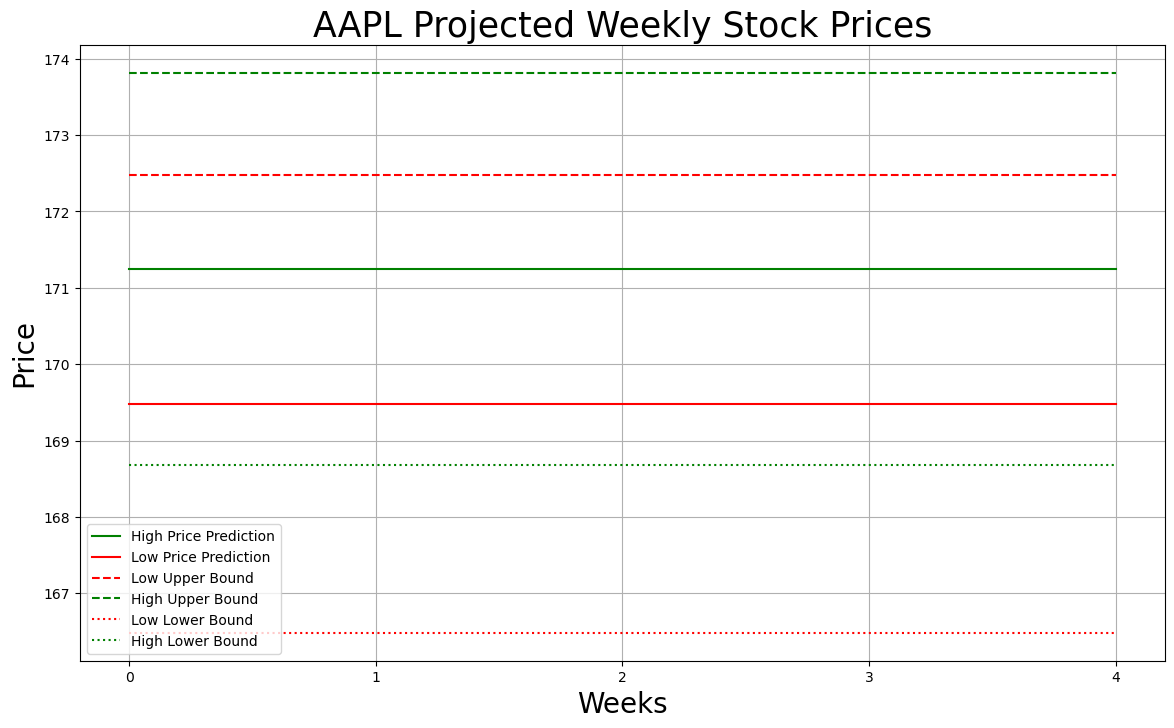

In [53]:
def forecast_prices_weekly(weekly_data, stock_symbol):
    MeanHigh, HighSD, _, _ = calculate_high_forecast_stats(weekly_data, stock_symbol)
    MeanLow, LowSD, _, _ = calculate_low_forecast_stats(weekly_data, stock_symbol)
    
    # Filter the data for the specified stock
    stock_data_weekly = weekly_data[weekly_data['Stock'] == stock_symbol].copy()
    
    # Get the last 4 weeks of data for prediction
    TrainDF_weekly = stock_data_weekly.iloc[-4:]

    # Use the WeeklyHighPrice function to get the projected high and low prices
    WeeklyHighDF = WeeklyHighPrice(TrainDF_weekly)
    HighPrediction = WeeklyHighDF['ProjectedHigh'].tail(1)

    WeeklyLowDF = WeeklyLowPrice(TrainDF_weekly)  
    LowPrediction = WeeklyLowDF['ProjectedLow'].tail(1)

    # Calculate Upper/Lower Bounds for High/Low Prices
    LLB = LowPrediction - (LowPrediction * (LowSD/100)) / 2
    LUB = LowPrediction + (LowPrediction * (LowSD/100)) / 2
    HLB = HighPrediction - (HighPrediction * (HighSD/100)) / 2
    HUB = HighPrediction + (HighPrediction * (HighSD/100)) / 2

    
    # Prepare the data for projection

    print("Regression Accuracy Over Past 4 Time Periods\n")
    print(f"Mean Margin of Error: {MeanHigh}%")
    print(f"Standard Deviation of Error: {HighSD}%")
    print(f"Deviation Range: {MeanHigh - HighSD}% - {MeanHigh + HighSD}%\n")
    
    num_weeks = len(TrainDF_weekly) + 1
    ProjectionChart = {
        'Time': range(len(TrainDF_weekly) + 1), 
        'High Price Prediction': [HighPrediction[0]] * (len(TrainDF_weekly) + 1),
        'Low Price Prediction': [LowPrediction[0]] * (len(TrainDF_weekly) + 1),
        'Low Upper Bound': [LUB[0]] * (len(TrainDF_weekly) + 1),
        'High Upper Bound': [HUB[0]] * (len(TrainDF_weekly) + 1),
        'Low Lower Bound': [LLB[0]] * (len(TrainDF_weekly) + 1),
        'High Lower Bound': [HLB[0]] * (len(TrainDF_weekly) + 1)
    }

    Testing_weekly = pd.DataFrame(ProjectionChart)

    # Plot the weekly forecast and bounds
    Testing_weekly.plot(x='Time', y=['High Price Prediction', 'Low Price Prediction',
                                     'Low Upper Bound', 'High Upper Bound',
                                     'Low Lower Bound', 'High Lower Bound'], style=['g', 'r', 'r--', 'g--', 'r:', 'g:'])
    plt.xlabel("Weeks", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.title(f"{stock_symbol} Projected Weekly Stock Prices", fontsize=25)
    plt.rcParams["figure.figsize"] = (14, 8)
    plt.grid(True)

    plt.xticks(range(num_weeks))

    plt.show()

# Usage example
forecast_prices_weekly(weekly_data, 'AAPL')


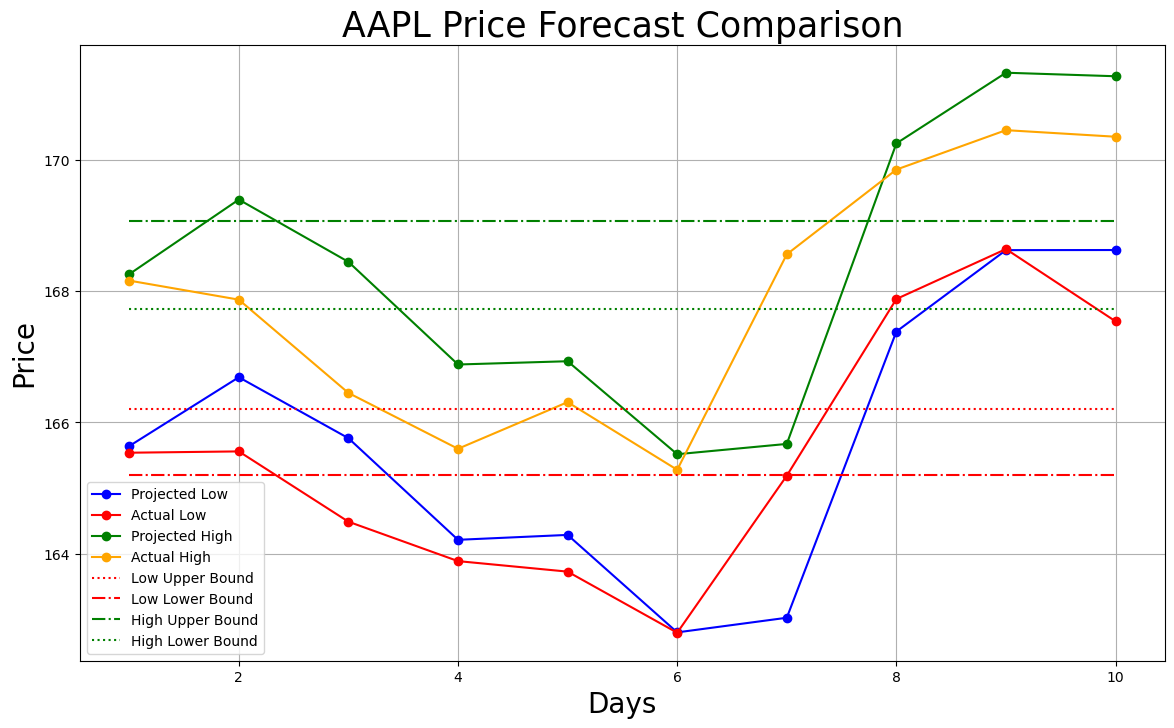

In [54]:
def combine_and_plot_forecasts(Stock_df, stock_symbol):
    # Get the forecast and actual data
    MeanLow, LowSD, LowProjections, ActualLows = calculate_low_forecast_stats(Stock_df, stock_symbol)
    MeanHigh, HighSD, HighProjections, ActualHighs = calculate_high_forecast_stats(Stock_df, stock_symbol)

    LowPredictionMean = statistics.mean(LowProjections)
    HighPredictionMean = statistics.mean(HighProjections[:len(LowProjections)])

    # Calculate bounds as straight lines based on the mean prediction
    LowUpperBound = LowPredictionMean + (LowPredictionMean * (LowSD/100)) / 2
    LowLowerBound = LowPredictionMean - (LowPredictionMean * (LowSD/100)) / 2
    HighUpperBound = HighPredictionMean + (HighPredictionMean * (HighSD/100)) / 2
    HighLowerBound = HighPredictionMean - (HighPredictionMean * (HighSD/100)) / 2

    # Prepare the combined data
    days = list(range(1, len(LowProjections) + 1))
    combined_data = {
        "Days": days,
        "Projected Low": LowProjections,
        "Actual Low": ActualLows,
        "Projected High": HighProjections[:len(LowProjections)],
        "Actual High": ActualHighs,
        "Low Upper Bound": [LowUpperBound] * len(days),
        "Low Lower Bound": [LowLowerBound] * len(days),
        "High Upper Bound": [HighUpperBound] * len(days),
        "High Lower Bound": [HighLowerBound] * len(days)
    }

    # Create DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(combined_df["Days"], combined_df["Projected Low"], label='Projected Low', marker='o', color='blue')
    plt.plot(combined_df["Days"], combined_df["Actual Low"], label='Actual Low', marker='o', color='red')
    plt.plot(combined_df["Days"], combined_df["Projected High"], label='Projected High', marker='o', color='green')
    plt.plot(combined_df["Days"], combined_df["Actual High"], label='Actual High', marker='o', color='orange')
    plt.plot(combined_df["Days"], combined_df["Low Upper Bound"], label='Low Upper Bound', linestyle=':', color='red')
    plt.plot(combined_df["Days"], combined_df["Low Lower Bound"], label='Low Lower Bound', linestyle='-.', color='red')
    plt.plot(combined_df["Days"], combined_df["High Upper Bound"], label='High Upper Bound', linestyle='-.', color='green')
    plt.plot(combined_df["Days"], combined_df["High Lower Bound"], label='High Lower Bound', linestyle=':', color='green')


    plt.xlabel("Days", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.title(f"{stock_symbol} Price Forecast Comparison", fontsize=25)
    plt.legend()
    plt.grid(True)
    plt.show()

   
# Example usage
combine_and_plot_forecasts(combined_df, 'AAPL')


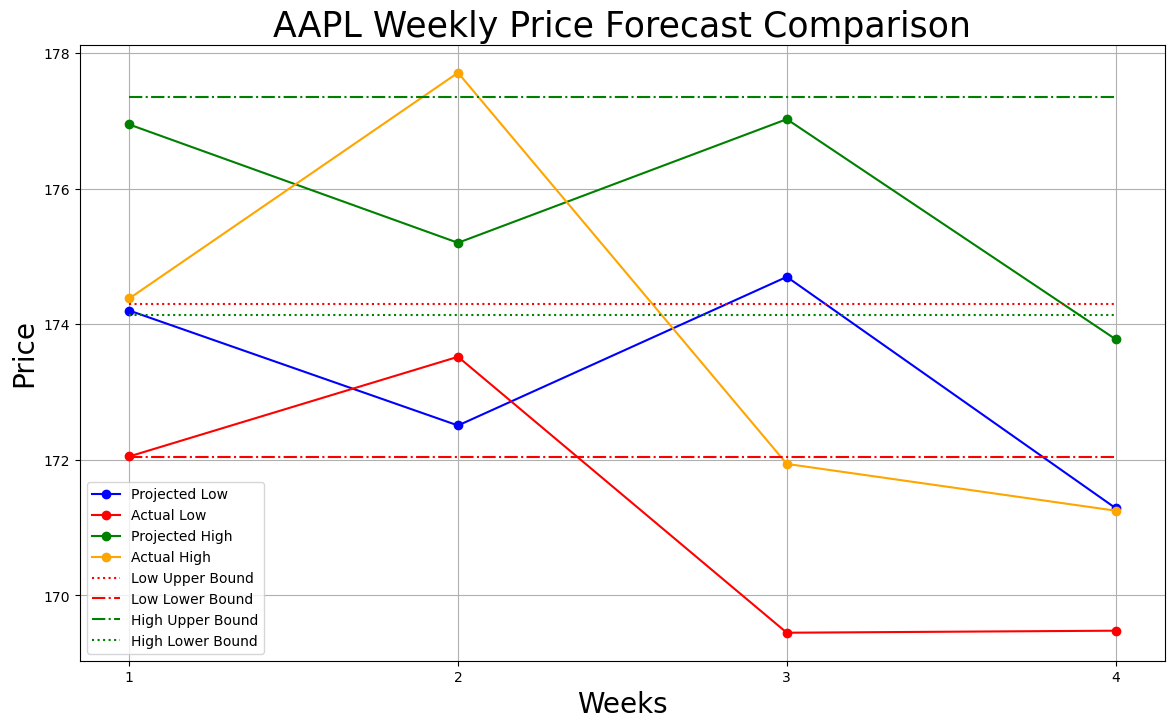

In [55]:
def combine_and_plot_weekly_forecasts(Stock_df, stock_symbol):
    # Calculate weekly forecasts for low and high prices
    MeanLow, LowSD, LowProjections, ActualLows = train_weekly_low_forecast(Stock_df, stock_symbol)
    MeanHigh, HighSD, HighProjections, ActualHighs = train_weekly_high_forecast(Stock_df, stock_symbol)

    weeks = np.arange(1, len(LowProjections) + 1)

    # Calculate straight line bounds for weekly forecasts
    LowPredictionMean = np.mean(LowProjections)
    HighPredictionMean = np.mean(HighProjections)

    LowUpperBound = LowPredictionMean + (LowPredictionMean * (LowSD/100)) / 2
    LowLowerBound = LowPredictionMean - (LowPredictionMean * (LowSD/100)) / 2
    HighUpperBound = HighPredictionMean + (HighPredictionMean * (HighSD/100)) / 2
    HighLowerBound = HighPredictionMean - (HighPredictionMean * (HighSD/100)) / 2

    # Combine all the data into a single DataFrame for plotting
    combined_weekly_data = {
        "Weeks": weeks,
        "Projected Low": LowProjections,
        "Actual Low": ActualLows,
        "Projected High": HighProjections,
        "Actual High": ActualHighs,
        "Low Upper Bound": [LowUpperBound] * len(weeks),
        "Low Lower Bound": [LowLowerBound] * len(weeks),
        "High Upper Bound": [HighUpperBound] * len(weeks),
        "High Lower Bound": [HighLowerBound] * len(weeks)
    }
    combined_weekly_df = pd.DataFrame(combined_weekly_data)

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Projected Low"], label='Projected Low', marker='o', color='blue')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Actual Low"], label='Actual Low', marker='o', color='red')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Projected High"], label='Projected High', marker='o', color='green')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Actual High"], label='Actual High', marker='o', color='orange')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Low Upper Bound"], label='Low Upper Bound', linestyle=':', color='red')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["Low Lower Bound"], label='Low Lower Bound', linestyle='-.', color='red')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["High Upper Bound"], label='High Upper Bound', linestyle='-.', color='green')
    plt.plot(combined_weekly_df["Weeks"], combined_weekly_df["High Lower Bound"], label='High Lower Bound', linestyle=':', color='green')

    plt.xlabel("Weeks", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.title(f"{stock_symbol} Weekly Price Forecast Comparison", fontsize=25)
    plt.legend()
    plt.grid(True)
    plt.xticks(weeks)
    plt.show()

# Usage Example
weekly_data = create_weekly_data(combined_df)  
combine_and_plot_weekly_forecasts(weekly_data, 'AAPL')

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_forecast_performance(data, actual_col, predicted_col, stock_symbol):

    stock_data = data[data['Stock'] == stock_symbol]
    
    filtered_data = stock_data.dropna(subset=[actual_col, predicted_col])

    y_test = filtered_data[actual_col]
    y_pred = filtered_data[predicted_col]

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

stock_symbol = 'AAPL'

# Evaluate High Price Forecast for daily data
high_daily_mse, high_daily_r2 = evaluate_forecast_performance(
    combined_df, 'High', 'ProjectedHigh', stock_symbol)

# Evaluate Low Price Forecast for daily data
low_daily_mse, low_daily_r2 = evaluate_forecast_performance(
    combined_df, 'Low', 'ProjectedLow', stock_symbol)

# Evaluate High Price Forecast for weekly data
high_weekly_mse, high_weekly_r2 = evaluate_forecast_performance(
    weekly_data, 'High', 'ProjectedHigh', stock_symbol)

# Evaluate Low Price Forecast for weekly data
low_weekly_mse, low_weekly_r2 = evaluate_forecast_performance(
    weekly_data, 'Low', 'ProjectedLow', stock_symbol)

print (stock_symbol)
print(f"Daily High Price - MSE: {high_daily_mse:.2f}, R2: {high_daily_r2:.2f}")
print(f"Daily Low Price - MSE: {low_daily_mse:.2f}, R2: {low_daily_r2:.2f}")
print(f"Weekly High Price - MSE: {high_weekly_mse:.2f}, R2: {high_weekly_r2:.2f}")
print(f"Weekly Low Price - MSE: {low_weekly_mse:.2f}, R2: {low_weekly_r2:.2f}")


AAPL
Daily High Price - MSE: 4.23, R2: 0.95
Daily Low Price - MSE: 4.46, R2: 0.95
Weekly High Price - MSE: 3.04, R2: 0.96
Weekly Low Price - MSE: 2.43, R2: 0.97


Displaying daily graphs for AAPL stock
Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



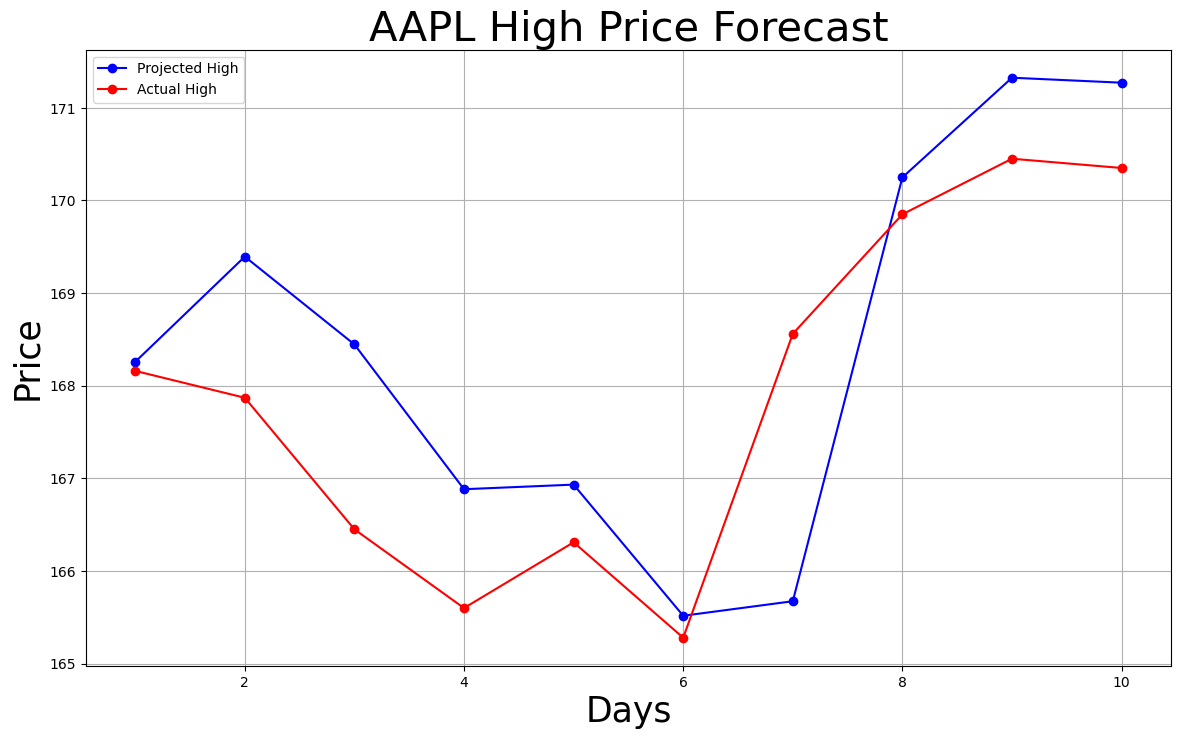

Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [16.9921008]%
Standard Deviation of Error: 0.6075602621856956%
Deviation Range: [16.38454053]% - [17.59966106]%



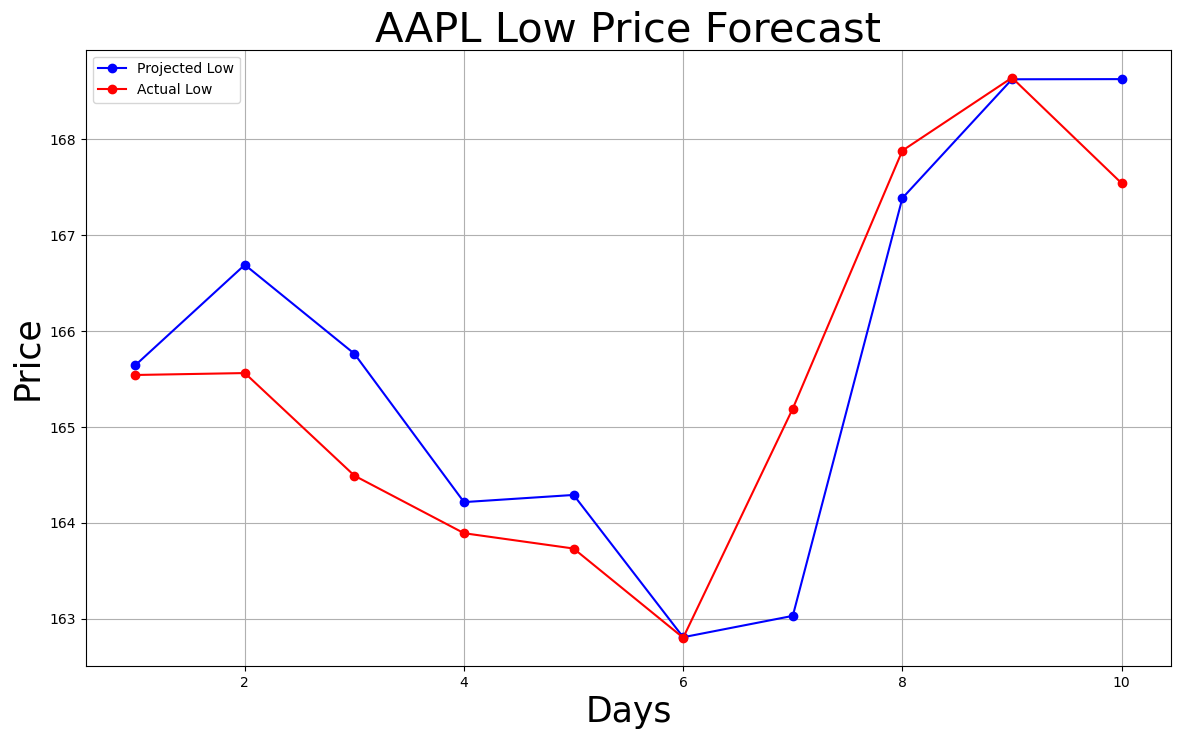

Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



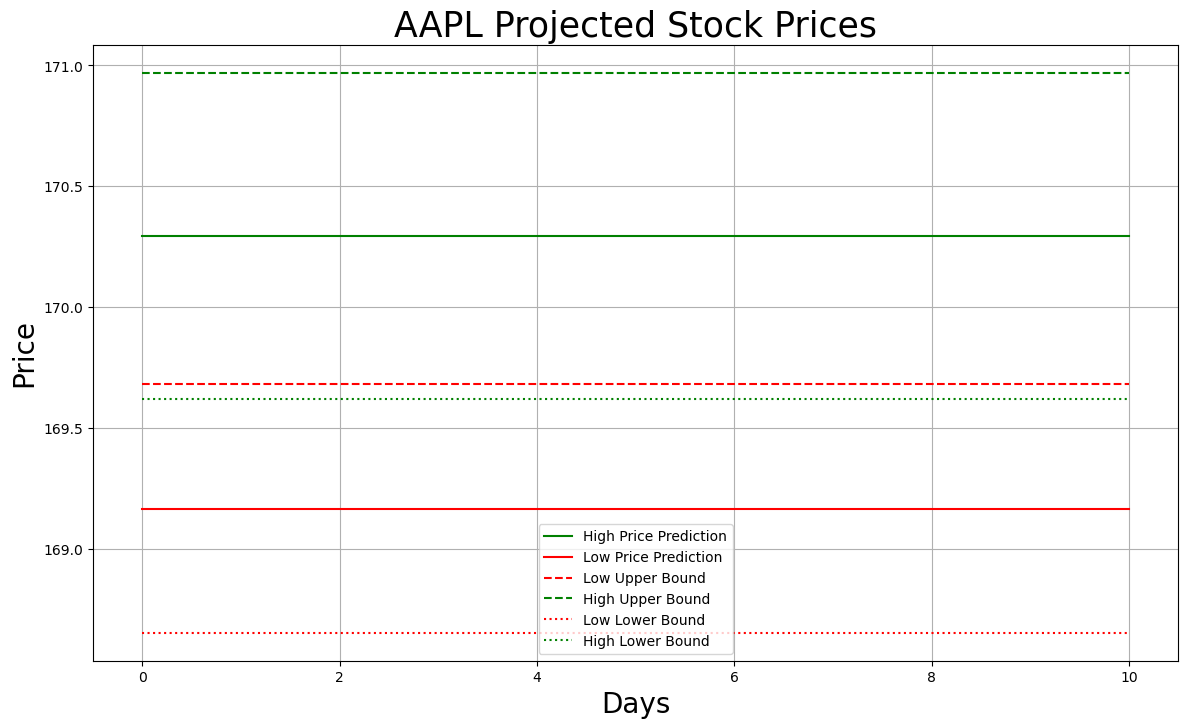

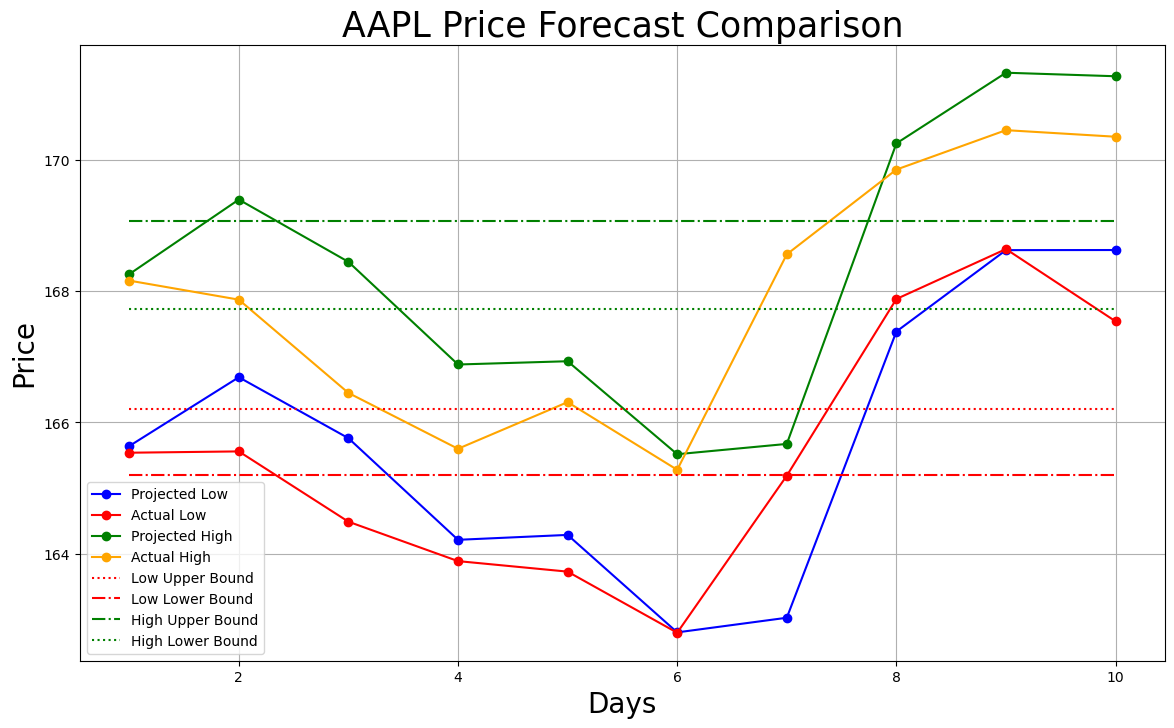

Displaying week graphs for AAPL stock
Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [44.56837997]%
Standard Deviation of Error: 1.8290705915730536%
Deviation Range: [42.73930938]% - [46.39745056]%



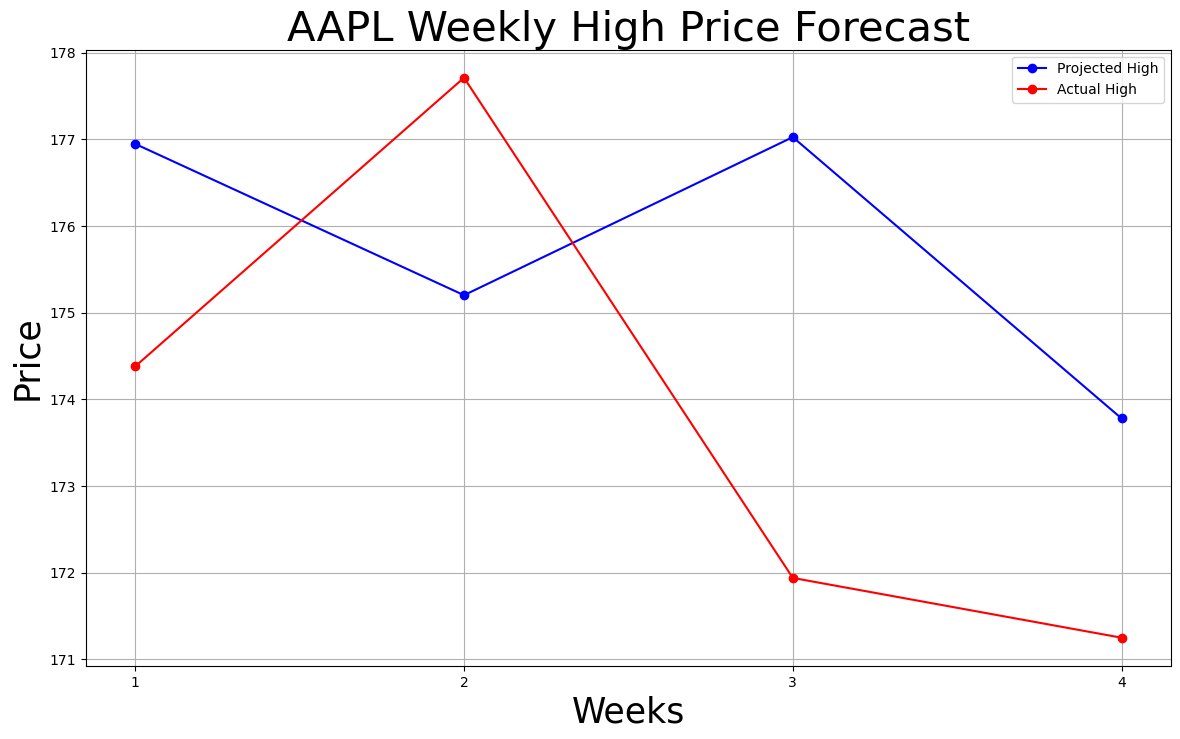

Regression Accuracy Over Past 10 Time Periods

Mean Margin of Error: [17.4524633]%
Standard Deviation of Error: 0.7921408612737285%
Deviation Range: [16.66032244]% - [18.24460416]%



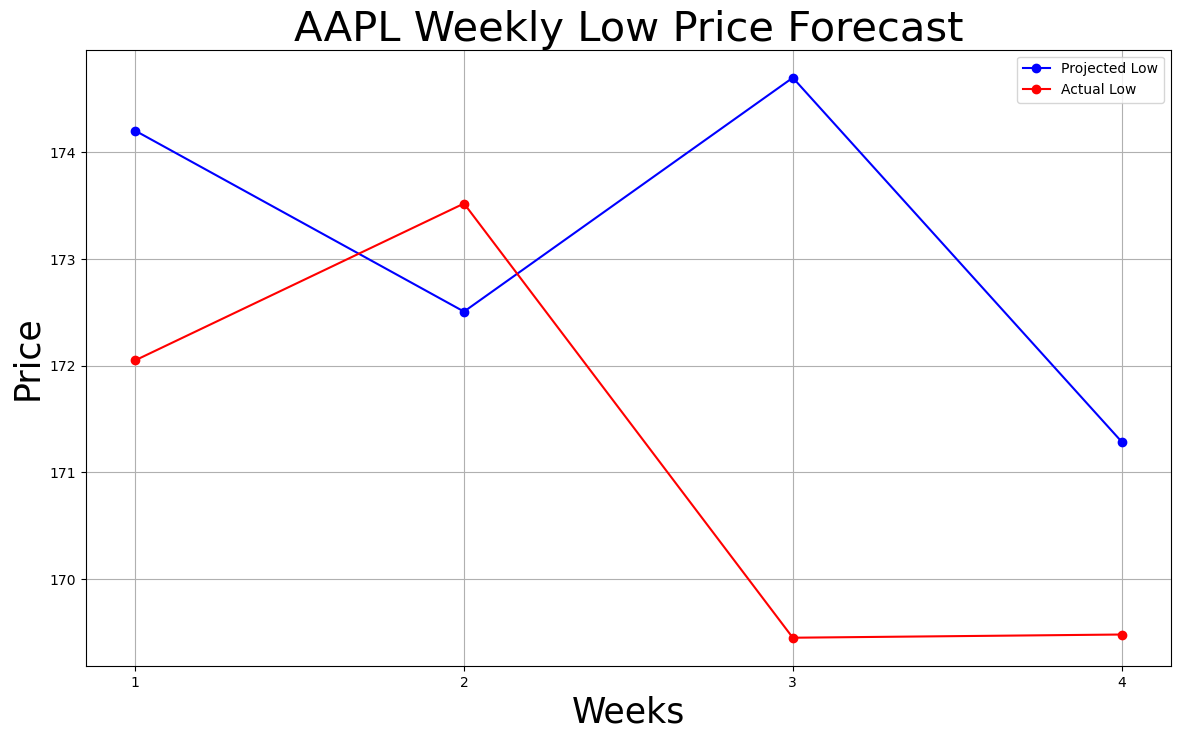

Regression Accuracy Over Past 4 Time Periods

Mean Margin of Error: [17.09974558]%
Standard Deviation of Error: 2.996089893086281%
Deviation Range: [14.10365569]% - [20.09583547]%



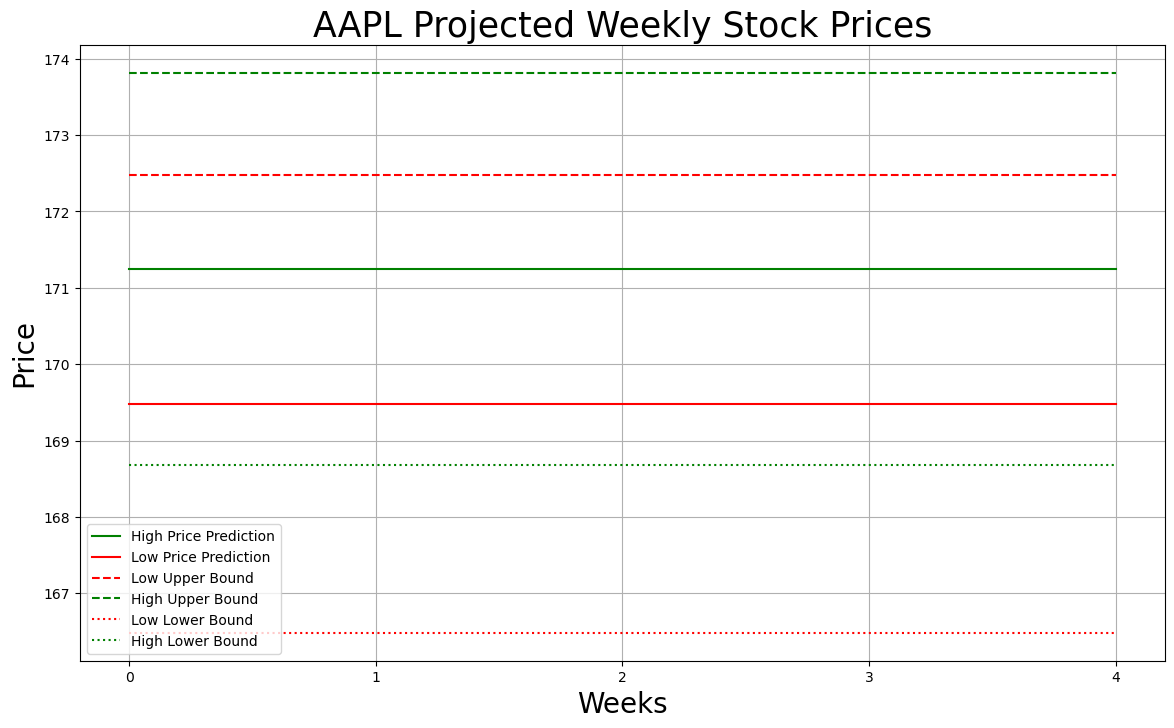

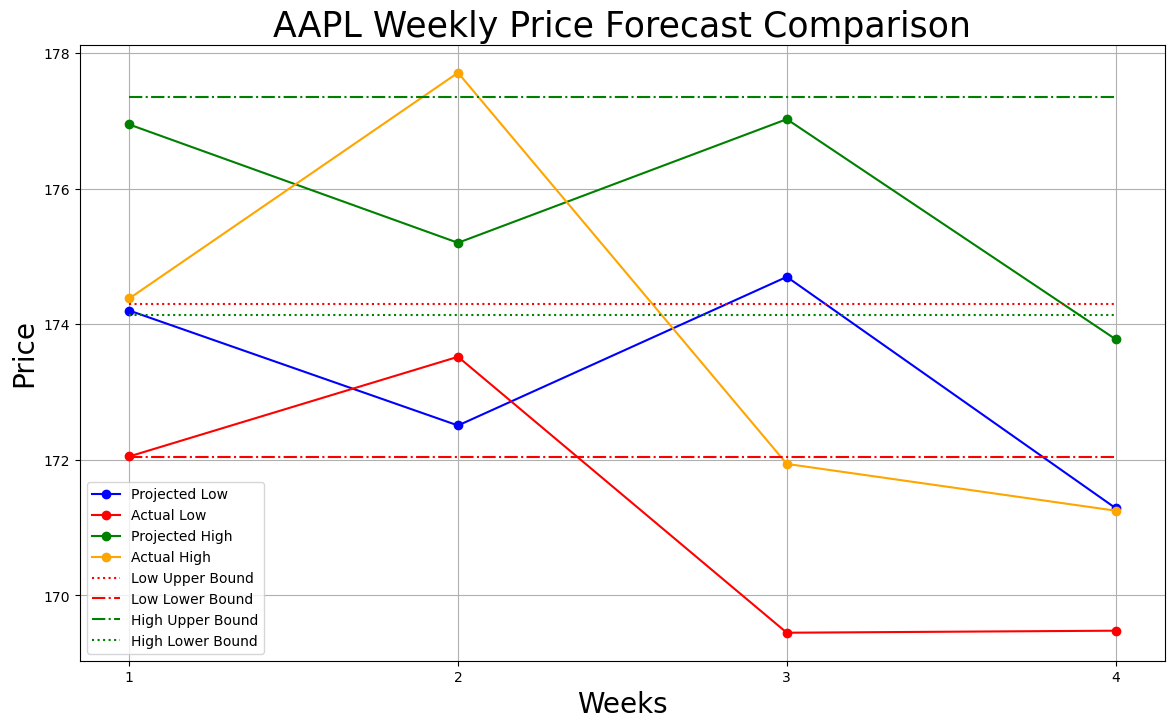

In [57]:
# Change the stock to graph the prediction
stock_symbol = 'AAPL'

#Display daily graphs first

#High daily Forecast 
print (f"Displaying daily graphs for {stock_symbol} stock")
MeanHigh, HighSD, Projections, Actuals = calculate_high_forecast_stats(combined_df, stock_symbol)
plot_high_forecast(stock_symbol, Projections, Actuals, MeanHigh, HighSD)

#Low daily Forecast 
MeanLow, LowSD, Projections, Actuals = calculate_low_forecast_stats(combined_df, stock_symbol)
plot_low_forecast(stock_symbol, Projections, Actuals, MeanLow, LowSD)

#Projected daily stock prices
forecast_prices(combined_df, stock_symbol)

combine_and_plot_forecasts(combined_df, stock_symbol)


#Display week forecast
print (f"Displaying week graphs for {stock_symbol} stock")

#High week Forecast 
weekly_data = create_weekly_data(combined_df)
plot_weekly_high_forecast(weekly_data, stock_symbol)

#Low week Forecast 
plot_weekly_low_forecast(weekly_data, stock_symbol)

#Projected week stock prices
forecast_prices_weekly(weekly_data, stock_symbol)

# Weekly Price Forecast Comparison
combine_and_plot_weekly_forecasts(weekly_data, stock_symbol)
